In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests

from utilsPlots import *


In [2]:
datadir = Path('../../datadir')

figdir = Path('./figs')
figdir.mkdir(exist_ok=True, parents=True)


In [3]:
df_info = pd.read_csv(datadir / 'participant_info.csv')
df_feat = pd.read_csv(datadir / 'video_features.csv')
df_all = df_info.merge(df_feat, on=['ID', 'day'])

df_feat_key = pd.read_csv(datadir / 'feature_key.csv')
oc_feats = df_feat_key.feature_code.values.tolist()

feat_name_map = dict(zip(df_feat_key.feature_code, df_feat_key.name))
feat_unit_map = dict(zip(df_feat_key.feature_code, df_feat_key.units))


	p=1.00000 10mwrt_speed FSHD, DM [58 28 43]
*	p=0.01109 10mwrt_stride_time FSHD, DM [58 28 43]
**	p=0.00902 10mwrt_stride_len FSHD, DM [58 28 43]
	p=0.16266 10mwrt_ankle_elev FSHD, DM [58 28 43]
	p=1.00000 10mwrt_com_sway FSHD, DM [58 28 43]
	p=1.00000 10mwrt_trunk_lean FSHD, DM [58 28 43]
	p=1.00000 10mwrt_mean_ptp_hip_add FSHD, DM [58 28 43]
	p=1.00000 10mwrt_mean_max_ka FSHD, DM [58 28 43]
	p=1.00000 10mwt_speed FSHD, DM [58 28 43]
	p=1.00000 10mwt_stride_time FSHD, DM [58 28 43]
**	p=0.00325 10mwt_stride_len FSHD, DM [58 28 43]
*	p=0.03655 10mwt_ankle_elev FSHD, DM [58 28 43]
	p=1.00000 10mwt_com_sway FSHD, DM [58 28 43]
	p=1.00000 10mwt_trunk_lean FSHD, DM [58 28 43]
	p=1.00000 10mwt_mean_ptp_hip_add FSHD, DM [58 28 43]
	p=1.00000 10mwt_mean_max_ka FSHD, DM [58 28 43]
	p=1.00000 tug_cone_time FSHD, DM [58 28 43]
	p=0.81564 tug_cone_turn_avel FSHD, DM [58 28 43]
	p=1.00000 tug_cone_turn_max_avel FSHD, DM [58 28 43]
	p=1.00000 5xsts_time_5 FSHD, DM [58 28 43]
	p=1.00000 5xsts_lean_m

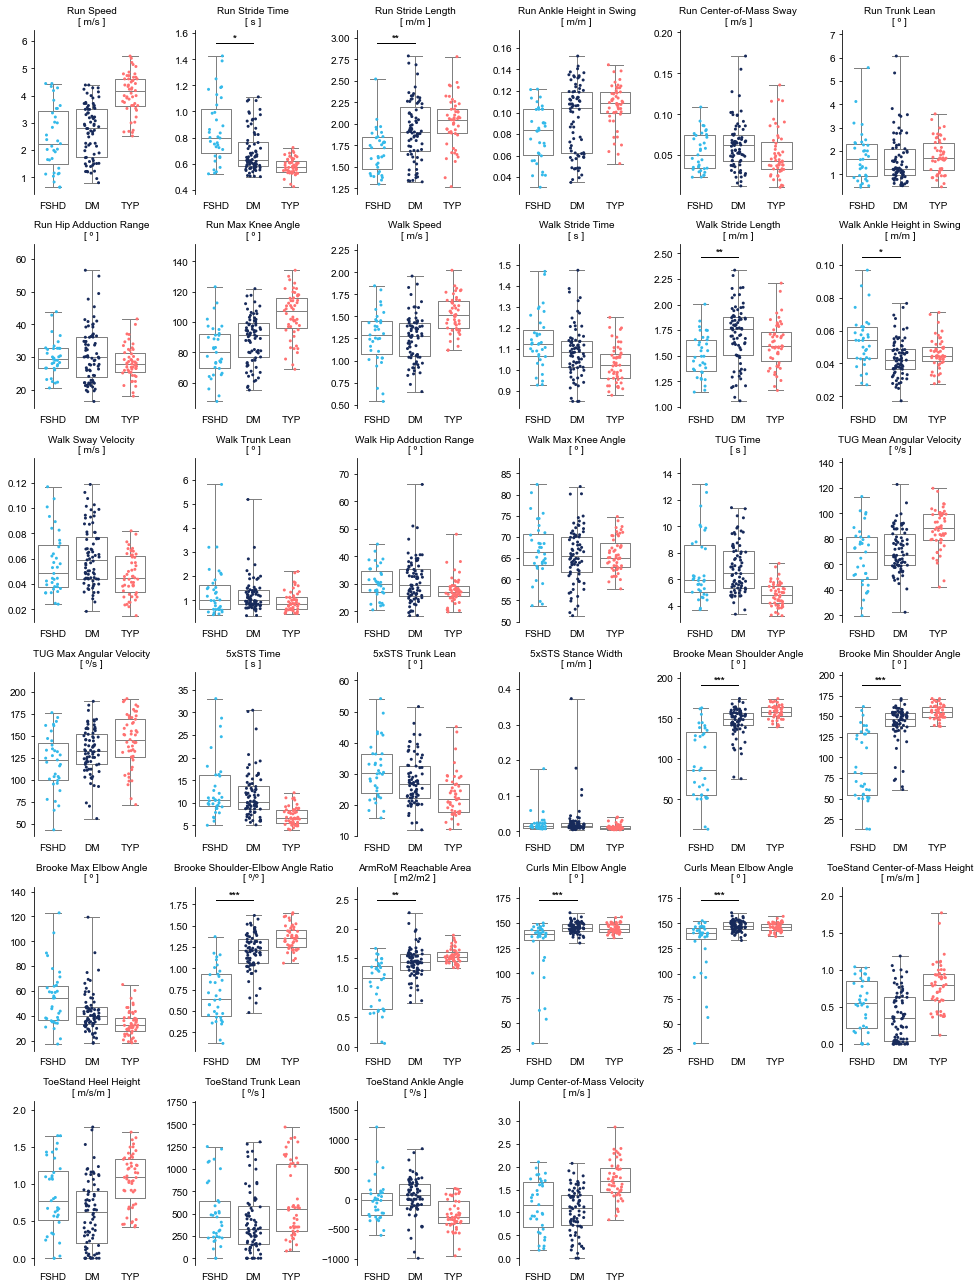

In [4]:
types = ['FSHD', 'DM', 'TYP']
colors = [cp[3], cp[0], cp[1]]
feats = oc_feats

ncols = min(len(feats), 6)
nrows = len(feats) // ncols + 1

plt.figure(figsize=(2.25*ncols,3*nrows))
pvals = []
for i, feat in enumerate(feats):

    df = df_all.dropna(subset=feats)
    df = df[df.type.isin(types)]

    plt.subplot(nrows,ncols, i+1)
    sns.boxplot(df, x='type', y=feat, hue='type', order=types,
                hue_order=types, linewidth=1, whis=[0, 100],
                palette=['#808080']*len(types), saturation=1, fill=None,  legend=False)
    np.random.seed(0)
    sns.stripplot(df, x='type', y=feat, order=types, size=3, jitter=0.2,
                  hue='type', hue_order=types, palette=colors)

    for a in range(len(types)-1):
        for b in range(a+1, len(types)):
            typea, typeb = types[a], types[b]
            if 'TYP' in [typea, typeb]: # do not test typical movement versus disease
                continue
            result = ks_2samp(
                df[df.type==typea][feat],
                df[df.type==typeb][feat],
                alternative='two-sided',
            )
            pval = result.pvalue
            pvals.append((i, a, b, pval))

pvals = np.array(pvals)

_, pvals_corrected, _, _ = multipletests(pvals[:,-1], method='bonferroni')
for i, pval in enumerate(pvals_corrected):
    pvals[i,-1] = pval

for (i, a, b, pval) in pvals:
    i, a, b = int(i), int(a), int(b)
    feat = feats[i]
    typea = types[a]
    typeb = types[b]

    plt.subplot(nrows,ncols, i+1)

    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    else:
        stars = ''

    print(f'{stars}\tp={pval:0.5f} {feat} {typea}, {typeb}',
          df.groupby('type').ID.nunique().values)
    y = df[feat].max() + np.ptp(df[feat])*0.1*(a+b)
    if stars:
        plt.plot([a, b], [y, y], c='k', lw=1,
                 marker=None)
        plt.text((a+b)/2, y, stars, ha='center', va='bottom', weight='bold')
    sns.despine(bottom=True)
    plt.gca().tick_params(bottom=False)
    plt.ylim(plt.ylim()[0], y+np.ptp(df[feat])*0.1)
    plt.title(f'{feat_name_map[feat]}\n[ {feat_unit_map[feat]} ]', fontsize=10)
    plt.xlabel(None)
    # plt.xlabel(feat_name_map[feat])
    plt.ylabel(None)

plt.tight_layout()
plt.savefig(figdir / 'fig5_signatures.pdf')
plt.show()
